In [8]:
# Standard-Bibliotheken
import warnings
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn: Modellselektion und Validierung
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Scikit-learn: Feature-Engineering
from sklearn.feature_extraction.text import TfidfVectorizer

# Scikit-learn: Modelle
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import tree 



# Scikit-learn: Metriken
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Scikit-learn: Pipeline
from sklearn.pipeline import Pipeline

# Warnungen ignorieren
warnings.simplefilter(action='ignore', category=FutureWarning)

### OPT 1: Laden Preprocess datei (Daten Test u. Train seperat)
- inkl. Aufteilung X_train, X_test, y_train, y_test, X_dev, y_dev

In [2]:
data_train = pd.read_csv("preprocessed/dataLemmaLowerStop_train.csv", on_bad_lines='skip', sep=';')
data_test = pd.read_csv("preprocessed/dataLemmaLowerStop_test.csv", on_bad_lines='skip', sep=';')

X_train = data_train['text']
y_train = data_train['group']
X_test =  data_test['text']
y_test = data_test['group']

X_test, X_dev, y_test, y_dev = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_dev.shape)
print(y_dev.shape)


(2624,)
(2624,)
(328,)
(328,)
(328,)
(328,)


### OPT 2: Laden Preprocess datei (Daten Test u. Train zsm.)
- inkl. Aufteilung X_train, X_test, y_train, y_test, X_dev, y_dev

In [ ]:
data = pd.read_csv("preprocessed/dataLemmaLowerStop.csv", on_bad_lines='skip', sep=';')
data = data.iloc[:,1:3]

X_train, X_test, y_train, y_test = train_test_split(
    data['text'], data['group'], test_size=0.2, random_state=42, stratify=data['group']
)

X_test, X_dev, y_test, y_dev = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_dev.shape)
print(y_dev.shape)

### OPT 3: Laden 20newgroups unprocessed
- inkl. Aufteilung X_train, X_test, y_train, y_test, X_dev, y_dev

In [ ]:
data = pd.read_csv("20 newsgroups/20newsgroups.csv", on_bad_lines='skip', sep=';')
data = data.dropna()
data = data.drop_duplicates()
data = data.iloc[:,1:3]

X_train, X_test, y_train, y_test = train_test_split(
    data['text'], data['group'], test_size=0.2, random_state=42, stratify=data['group']
)

X_test, X_dev, y_test, y_dev = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_dev.shape)
print(y_dev.shape)

### Tree Classifier ermittlung bester clf und tree Params (RandomizedSearchCV)
- Um herauszufinden welche Parameter mit GridSearchCV genauer untersucht werden müssen
- Zum testet n zufälliger Kombinationen der angegebenen tfidf und clf Parametern (n_iter), um eine Kombination mit gutem F1 Wert zu finden
- Verwendung Pipelin um TF-IDF-Vektorisierung und TreeClassifier zu vereinheitlichen

Erkentnisse:
- clf__criterion gini beim trainieren mit vektoren immer am besten
- min_sample_split 2 am besten
- min saplee_leaf 1 am besten

Erklärungen Parameter:
    Params TfidfVectorizer:
        - tfidf__max_df: Maximale Häufigkeit eines Begriffs in Dokumenten.
        - tfidf__min_df: Minimale Häufigkeit eines Begriffs in Dokumenten.
        - tfidf__max_features: Maximale Anzahl der zu extrahierenden Begriffe.
        - tfidf__sublinear_tf eine Möglichkeit, die Bedeutung häufiger Begriffe in den Dokumenten zu dämpfen
        - clf__max_depth: Maximale Tiefe des Entscheidungsbaums.
        - clf__min_samples_split: Minimale Anzahl an Proben, um einen Knoten zu teilen.
        - clf__criterion: Bewertungsfunktion für den Entscheidungsbaum. (entropy:feiner; gini:grober)
        - clf__min_samples_leaf: Minimale Anzahl an Proben in einem Blatt des Entscheidungsbaums.
    
    Params RandomizedSearchCV:
        - CV: Technik, um die Leistung eines Modells besser zu bewerten und Überanpassung (Overfitting) zu vermeiden. Dabei wird der verfügbare Datensatz in mehrere Teile (sogenannte Folds) aufgeteilt, und das Modell wird mehrfach trainiert und getestet.

In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_df=0.8,
        min_df=2,
        ngram_range=(1, 2),
        stop_words='english',
        max_features=5000,
        clf__criterion='gini'
    )),
    ('clf', DecisionTreeClassifier(random_state=42))
])

param_distributions = {
    'tfidf__max_df': [0.1, 0.2, 0.5, 0.7, 0.8, 0.9],
    'tfidf__min_df': [1, 2, 5],
    'tfidf__max_features': [500, 1000, 3000, 5000, 10000, 15000, None],
    'tfidf__sublinear_tf': [True, False],
    'clf__max_depth': [60, 130, 140, 150, 160, 180, 200], 
    'clf__min_samples_split': [2, 3],
    'clf__min_samples_leaf': [1, 2]
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=400,                   # Anzahl der zu testenden zufälligen Kombinationen
    cv=5,                         # 5-fache Cross-Validation
    scoring='f1_macro',           # Optimierung auf F1-Score (macro)
    random_state=42,              # Zufälligkeit kontrollieren
    n_jobs=-1                     # Parallele Verarbeitung
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Beste Parameter:", best_params)

best_pipeline = random_search.best_estimator_

y_dev_pred = pipeline.predict(X_dev)

print("F1-Score: ", f1_score(y_dev, y_dev_pred, average='macro'))
print("Precision: ", precision_score(y_dev, y_dev_pred, average='macro'))
print("Recall: ", recall_score(y_dev, y_dev_pred, average='macro'))
print(classification_report(y_dev, y_dev_pred))

### Tree Classifier ermittlung bester clf und tree Params (GridSearchCV)

- Zum genauen testen aller Kombinationen der angegebenen tfidf und clf Parametern, um die mit dem besten F1 Wert zu finden
- Verwendung Pipelin um TF-IDF-Vektorisierung und TreeClassifier zu vereinheitlichen


Erklärungen Paramerter:
    Params TfidfVectorizer:
        - tfidf__max_df: Maximale Häufigkeit eines Begriffs in Dokumenten.
        - tfidf__min_df: Minimale Häufigkeit eines Begriffs in Dokumenten.
        - tfidf__max_features: Maximale Anzahl der zu extrahierenden Begriffe.
        - tfidf__sublinear_tf eine Möglichkeit, die Bedeutung häufiger Begriffe in den Dokumenten zu dämpfen
        - clf__max_depth: Maximale Tiefe des Entscheidungsbaums.
        - clf__min_samples_split: Minimale Anzahl an Proben, um einen Knoten zu teilen.
        - clf__criterion: Bewertungsfunktion für den Entscheidungsbaum. (entropy:feiner; gini:grober)
        - clf__min_samples_leaf: Minimale Anzahl an Proben in einem Blatt des Entscheidungsbaums.
    
    Params RandomizedSearchCV:
        - CV: Technik, um die Leistung eines Modells besser zu bewerten und Überanpassung (Overfitting) zu vermeiden. Dabei wird der verfügbare Datensatz in mehrere Teile (sogenannte Folds) aufgeteilt, und das Modell wird mehrfach trainiert und getestet.

In [3]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_df=0.8,
        min_df=2,
        ngram_range=(1, 2), #TODO Anpassen für kontext => bisher (1,1) bestes Ergebnis
        stop_words='english',
        max_features=5000
    )),
    ('clf', DecisionTreeClassifier(random_state=42))
])

param_grid = {
    'tfidf__max_df': [0.5, 1.0, 1.5],             
    'tfidf__min_df': [1, 2],                 
    'tfidf__max_features': [4500, 5000, 5500], 
    'tfidf__sublinear_tf': [True, False],           
    'clf__min_samples_split': [2, 3],           
    'clf__min_samples_leaf': [1, 2],            
    'clf__max_depth': [130, 190, 200],        
    'clf__criterion': ['gini'],          
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                          # 5-fache Cross-Validation
    scoring='f1_macro',            # Optimierung auf F1-Score (macro)
    n_jobs=-1                      # Parallele Verarbeitung
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Beste Parameter:", best_params)

best_pipeline = grid_search.best_estimator_

y_dev_pred = best_pipeline.predict(X_dev)

print("F1-Score: ", f1_score(y_dev, y_dev_pred, average='macro'))
print("Precision: ", precision_score(y_dev, y_dev_pred, average='macro'))
print("Recall: ", recall_score(y_dev, y_dev_pred, average='macro'))
print(classification_report(y_dev, y_dev_pred))

KeyboardInterrupt: 

## Tree Classifier mit Vektor trainieren (ohne Search)
- Zum testen der momentan besten durch 

In [4]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        sublinear_tf=True,      
        min_df=2,                
        max_features=5600,     
        ngram_range=(1, 1),  
        max_df=0.05,              
        stop_words='english'     
    )),
    ('clf', DecisionTreeClassifier(
        random_state=42,         
        min_samples_split=2,     
        min_samples_leaf=1,      
        max_depth=200,           
        criterion='gini'         
    ))
])

pipeline.fit(X_train, y_train)

y_dev_pred = pipeline.predict(X_dev)

print("F1-Score: ", f1_score(y_dev, y_dev_pred, average='macro'))
print("Precision: ", precision_score(y_dev, y_dev_pred, average='macro'))
print("Recall: ", recall_score(y_dev, y_dev_pred, average='macro'))
print(classification_report(y_dev, y_dev_pred))

F1-Score:  0.6960569199640945
Precision:  0.7128091328815769
Recall:  0.6923751686909582
              precision    recall  f1-score   support

           0       0.69      0.53      0.60        78
           1       0.84      0.80      0.82        95
           2       0.62      0.81      0.70        95
           3       0.69      0.63      0.66        60

    accuracy                           0.71       328
   macro avg       0.71      0.69      0.70       328
weighted avg       0.72      0.71      0.70       328



### Ermittlung endgültiger F1-Score (an ungesehenen Testdaten)

In [5]:
y_dev_pred = pipeline.predict(X_test)
print("F1-Score: ", f1_score(y_test, y_dev_pred, average='macro'))
print("Precision: ", precision_score(y_test, y_dev_pred, average='macro'))
print("Recall: ", recall_score(y_test, y_dev_pred, average='macro'))
print(classification_report(y_test, y_dev_pred))

F1-Score:  0.7171292513855766
Precision:  0.7268508327830361
Recall:  0.7153014802281411
              precision    recall  f1-score   support

           0       0.68      0.58      0.63        77
           1       0.88      0.78      0.83        95
           2       0.68      0.84      0.75        95
           3       0.67      0.66      0.66        61

    accuracy                           0.73       328
   macro avg       0.73      0.72      0.72       328
weighted avg       0.74      0.73      0.73       328



### Importancewerte nach Training mit TreeClassifier ausgeben

Wichtigste Features:
        Feature  Importance
3588      orbit    0.041607
2096     format    0.035055
626     atheist    0.030518
4556    shuttle    0.025961
1033  christian    0.023996
2417         hi    0.023444
2282   graphics    0.022445
191          3d    0.017801
1115      color    0.017194
2932     launch    0.016404


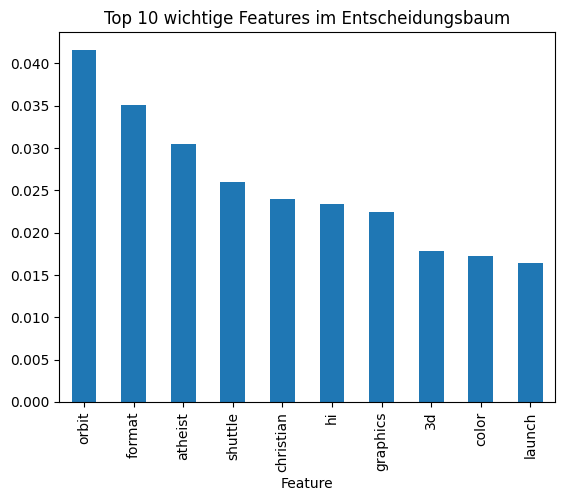

In [21]:
clf = pipeline.named_steps['clf']  
tfidf = pipeline.named_steps['tfidf']  

feature_names = tfidf.get_feature_names_out()

importances = clf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Wichtigste Features:")
print(importance_df.head(10))

importance_df.head(10).plot(kind="bar", x="Feature", y="Importance", legend=False)
plt.title("Top 10 wichtige Features im Entscheidungsbaum")
plt.show()

### Optional: Speichern TFIDF-Matrix in csv


In [ ]:
tfidf = pipeline.named_steps['tfidf']

tfidf_matrix = tfidf.transform(X_train)

tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(), 
    columns=tfidf.get_feature_names_out()
)

tfidf_df.to_csv("tfidf_matrix.csv", index=False, sep=';')
print("TF-IDF-Matrix wurde gespeichert.")

print(tfidf_df.head())


data_train['average_tfidf'] = tfidf_matrix.mean(axis=1)
average_per_class = data_train.groupby('group')['average_tfidf'].mean()
print("\nDurchschnittliche TF-IDF-Werte pro Klasse:\n", average_per_class)

### Optional: Histogramm Verteilung der TF-IDF-Werte plotten

In [ ]:
tfidf_values = tfidf_df.values.flatten()

plt.hist(tfidf_values, bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title("Häufigkeitsverteilung der TF-IDF-Werte")
plt.xlabel("TF-IDF-Wert")
plt.ylabel("Häufigkeit")
plt.yscale('log')  
plt.show()

### Optional: Entscheidungsbaum ploten

[Text(0.6527777777777778, 0.9, 'orbit <= 0.014\ngini = 0.742\nsamples = 2624\nvalue = [621, 758, 762, 483]'),
 Text(0.4166666666666667, 0.7, 'format <= 0.035\ngini = 0.744\nsamples = 2505\nvalue = [618, 757, 648, 482]'),
 Text(0.5347222222222222, 0.8, 'True  '),
 Text(0.2222222222222222, 0.5, 'atheist <= 0.007\ngini = 0.747\nsamples = 2396\nvalue = [618.0, 654.0, 643.0, 481.0]'),
 Text(0.1111111111111111, 0.3, 'shuttle <= 0.019\ngini = 0.746\nsamples = 2299\nvalue = [532, 652, 643, 472]'),
 Text(0.05555555555555555, 0.1, '\n  (...)  \n'),
 Text(0.16666666666666666, 0.1, '\n  (...)  \n'),
 Text(0.3333333333333333, 0.3, 'gospel <= 0.102\ngini = 0.205\nsamples = 97\nvalue = [86, 2, 0, 9]'),
 Text(0.2777777777777778, 0.1, '\n  (...)  \n'),
 Text(0.3888888888888889, 0.1, '\n  (...)  \n'),
 Text(0.6111111111111112, 0.5, 'jpl <= 0.079\ngini = 0.105\nsamples = 109\nvalue = [0, 103, 5, 1]'),
 Text(0.5555555555555556, 0.3, 'publisher <= 0.034\ngini = 0.055\nsamples = 106\nvalue = [0, 103, 2, 1]'

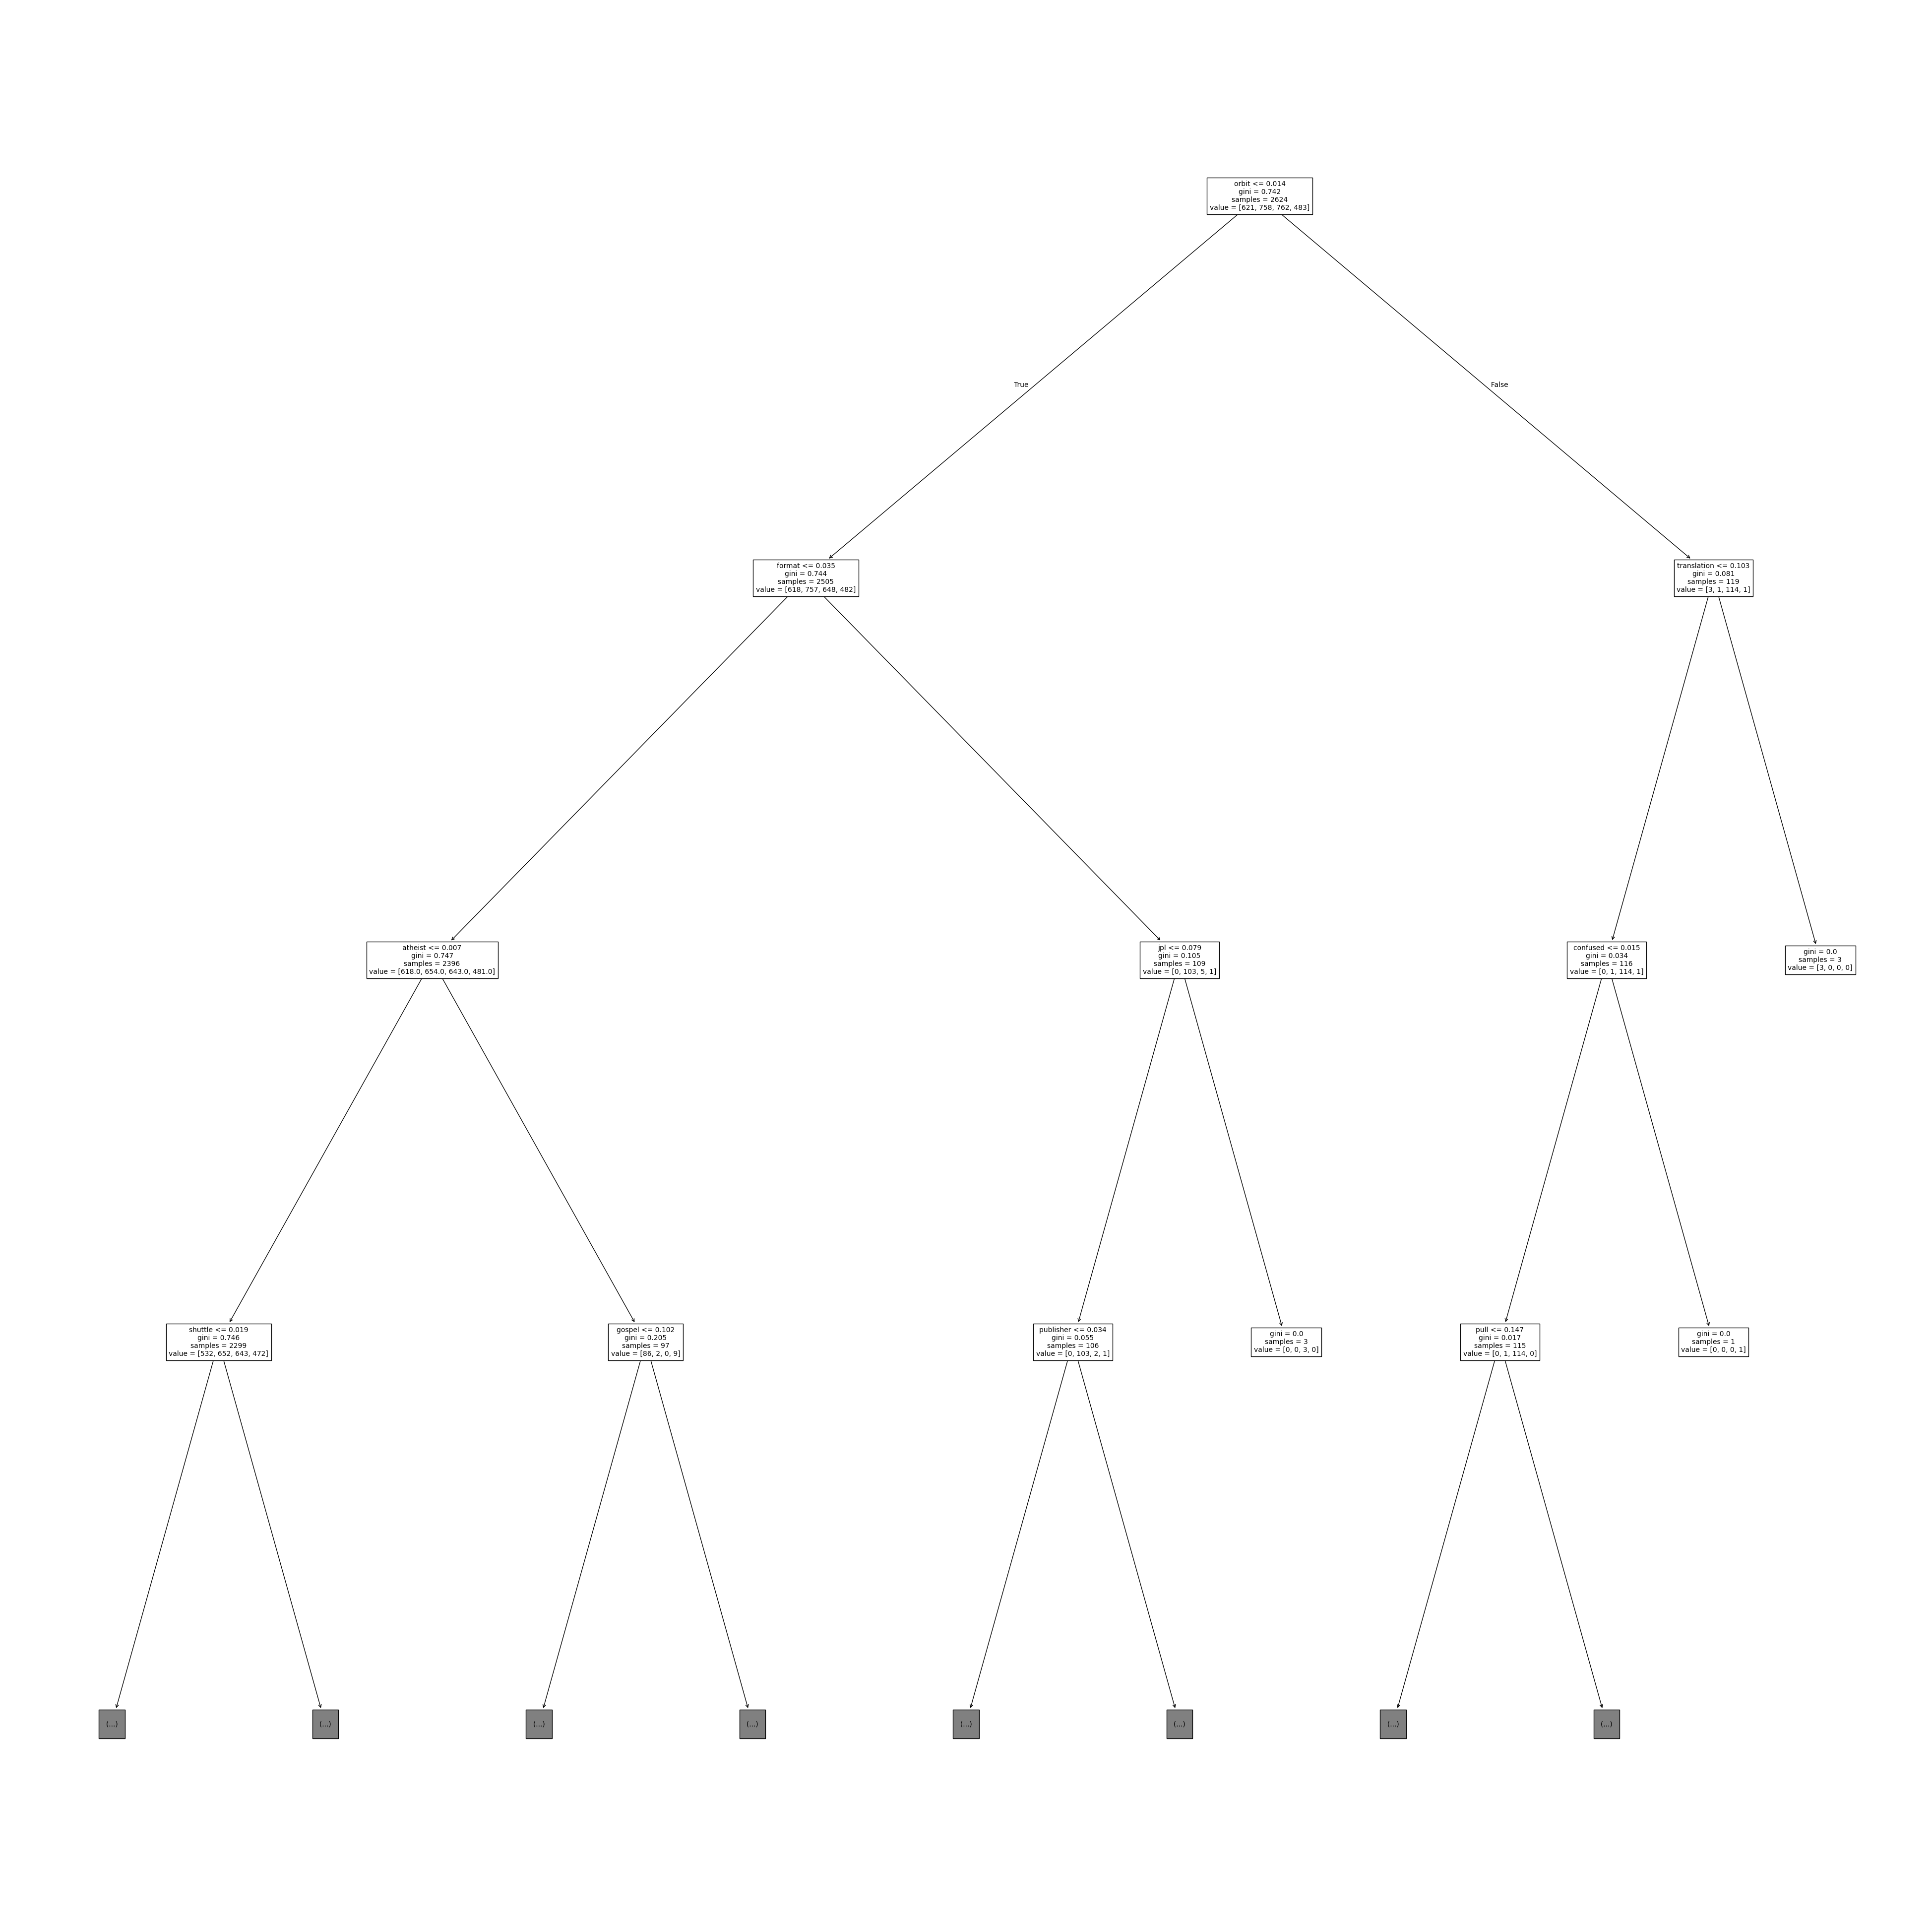

In [11]:
clf = pipeline.named_steps['clf']  
tfidf = pipeline.named_steps['tfidf']  


plt.figure(figsize=(50,50))
tree.plot_tree(clf,feature_names=list(tfidf.get_feature_names_out()), fontsize=10, max_depth=3)